In [ ]:
import os
import logging

import pandas as pd
import numpy as np

import h5py
import threading
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

DEP_FEATURE_NAME = 'surf_temp_sqerror'
HDF_LOCK = threading.Lock()
DATE_PATTERN = 'date%Y%m%d'
TIME_PATTERN = 'time%H%M'
KEY_PATTERN = '/{}/{}'.format(DATE_PATTERN, TIME_PATTERN)
STORE_PATH = 'metro_error_data_pro_swe2018.h5'

# Reduce log level
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

In [ ]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount', 'station_id']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = ['forecast_length'] + HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES
DEPENDENT_FEATURES = ['stn_{}'.format(f) for f in ['dew_point', 'surf_temp']]
ERROR_FEATURES = ['surf_temp_sqerror']

In [ ]:

start_time = datetime(2018, 9, 29, 5)
end_time = datetime(2018, 3, 14, 14)

def define_SSE(df, dep_feature_name):
    if dep_feature_name == 'surf_temp_sqerror':
        df[dep_feature_name] = (df['surf_temp'] - df['stn_surf_temp']) ** 2

def store_path(store_name):
    cwd = os.getcwd()
    return os.path.join(cwd, '{}.h5'.format(store_name))

def truncate_time(time):
    return time.replace(minute=10*(time.minute//10), second=0, microsecond=0)

def read(valid_time):
    valid_time = truncate_time(valid_time)
    with HDF_LOCK:
        with pd.HDFStore(STORE_PATH, 'r') as store:
            key = valid_time.strftime(KEY_PATTERN)
            if key in store:
                return store.get(key)

def gather_training_data(start_time, end_time):
    print('gathering training data from {} until {}'.format(start_time, end_time))
    ref_time = start_time
    dfs = []
    dfs.append(read(ref_time))
    df = pd.concat(dfs)
    print('Training data memory usage: {}Mb'.format(df.memory_usage().sum() / 10**6))
    return df

def train_test_splitter(df):
    define_target_features(df, dep_feature_name=DEP_FEATURE_NAME)
    return model

df = gather_training_data(start_time, end_time)
df.head()

In [219]:
for dep_feature_name in ERROR_FEATURES:
    # ['surf_temp_sqerror']:
    define_SSE(df, dep_feature_name=dep_feature_name)


included = np.array(df[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))
rsi = {
    "data": df.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
    "target": df.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
}
X_train, X_test, y_train, y_test = train_test_split(rsi["data"], rsi["target"], test_size=0.3, random_state=0)

mean = X_train.mean(axis=0)    
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test -= mean
X_test /= std

In [263]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu',
             input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [249]:

k = 4
num_val_samples = len(X_train) // k
num_epochs = 20
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
        X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=47, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [250]:
all_scores

[2.7381933733948274, 2.6905920273606547, 2.853444094817038, 2.5222634586028367]

In [251]:
np.mean(all_scores)

2.701123238543839

In [ ]:
model = build_model()
model.fit(X_train, y_train,
             epochs=80, batch_size=94, verbose=1)
test_val_mse, test_val_mae = model.evaluate(X_test, y_test, verbose=1)
print('Done!')

Epoch 1/80
9829/9829 [==============================] - 5s 486us/step - loss: 135.0928 - mean_absolute_error: 3.1806
Epoch 2/80
9829/9829 [==============================] - 1s 120us/step - loss: 133.0333 - mean_absolute_error: 3.0131
Epoch 3/80
9829/9829 [==============================] - 1s 115us/step - loss: 131.2567 - mean_absolute_error: 2.9039
Epoch 4/80
9829/9829 [==============================] - 1s 114us/step - loss: 130.2205 - mean_absolute_error: 2.8772
Epoch 5/80
9829/9829 [==============================] - 1s 130us/step - loss: 129.7704 - mean_absolute_error: 2.8531
Epoch 6/80
9829/9829 [==============================] - ETA: 0s - loss: 130.4022 - mean_absolute_error: 2.829 - 1s 122us/step - loss: 128.6890 - mean_absolute_error: 2.8230
Epoch 7/80
9829/9829 [==============================] - 1s 135us/step - loss: 126.2866 - mean_absolute_error: 2.7824
Epoch 8/80
9829/9829 [==============================] - 1s 128us/step - loss: 125.6528 - mean_absolute_error: 2.7896
Epoch 9/

In [265]:
test_val_mse, test_val_mae

(30.03916305763377, 2.3297615487587415)

Text(0, 0.5, 'Estimated surf_temp_sqerror')

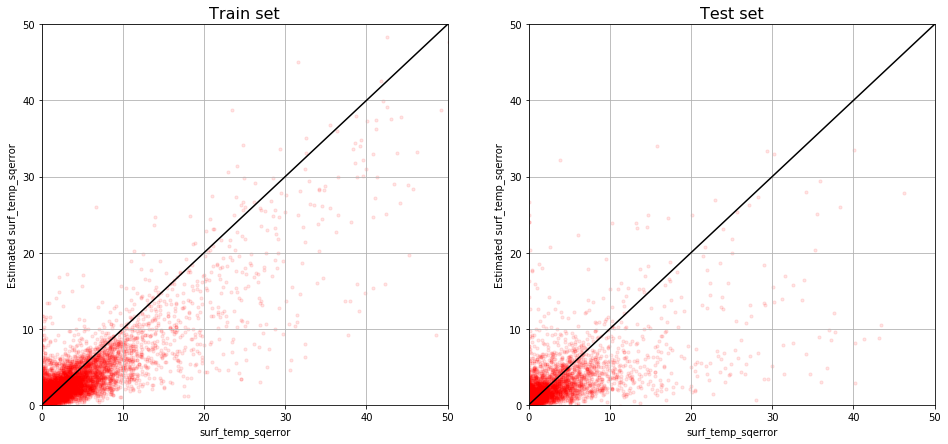

In [266]:
%matplotlib inline

from matplotlib import pyplot
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
plt.subplot(121)
pyplot.scatter(y_train, model.predict(X_train), color="red", alpha=0.1, s=10)
pyplot.xlim(0,50)
pyplot.ylim(0,50)
pyplot.plot(range(60), color='black')
pyplot.grid()
pyplot.title('Train set', fontsize=16)
pyplot.xlabel('surf_temp_sqerror')
pyplot.ylabel('Estimated surf_temp_sqerror')

plt.subplot(122)
pyplot.scatter(y_test, model.predict(X_test), color="red", alpha=0.1, s=10)
pyplot.xlim(0,50)
pyplot.ylim(0,50)
pyplot.plot(range(60), color='black')
pyplot.grid()
pyplot.title('Test set', fontsize=16)
pyplot.xlabel('surf_temp_sqerror')
pyplot.ylabel('Estimated surf_temp_sqerror')